# Compensation Lengthscale Estimation

This notebook outlines the approach to estimating the compensation lengthscale from the power law behavior of the spatial variabilty of sedimentation as measured with the methodology presented by Wang et al. (2011).

> Y. Wang, K. M. Straub, E. A. Hajek, Scale-dependent compensational stacking: An estimate of autogenic time scales in channelized sedimentary deposits. Geology. 39, 811–814 (2011).

This approach utilizes traces of "pseudo time horizons," which are assumed isochronous surfaces in a stratigraphy. The variability in thickness of sediments between surfaces is computed as a function of the increasing average stratigraphic thickness between time horizons.

In [1]:
import numpy as np
import pandas as pd
import shapely

import matplotlib.pyplot as plt

We will need a workflow that will move a window of increasing width (in average stratigraphic thickness between isochronous horizons), compute the average spatial thickness of sediments in that window, and then evaluate their variability. 

Thickness is evaluated in the conventional stratigraphic sense as the total length of sediment measured perpendicular to paleo horizontal. Paleo horizontal is not obvious in the sense that it must be inferred from the stratigraphy as an overall bedding attitude, despite the fact that local bedding planes may deviate significantly in their attitudes, and that sediments may not have even been accumulating on a "horizontal" surface. 

To begin, we will simply assume that we have some average sense of paleo horizontal, and that we can define the normal vector to that plane. 

In [2]:
import itertools
from shapely.geometry import LineString, box, Point
from tqdm.notebook import tqdm

def make_comb(point, bbox, vec):
    """
    given a point, bounding box, and vector, extend a line from the point in the direction of the vector until intersection with the bounding box
    
    point: (x, y)
    bbox: shapely box
    vec: (x, y)
    
    returns: (x0, x1), (y0, y1)
    """
    # initial coordinates of comb for current point
    cur_line_x = [point[0], point[0] + vec[0]]
    cur_line_y = [point[1], point[1] + vec[1]]
    
    bbox_coords = np.asarray(list(bbox.boundary.coords))
    xmin, ymin = np.min(bbox_coords, axis=0)
    xmax, ymax = np.max(bbox_coords, axis=0)
    
    # code from https://stackoverflow.com/questions/62388276/how-to-create-an-infinite-line-from-two-given-points-to-get-intersection-with-ot
    if cur_line_x[0] == cur_line_x[1]:  # vertical line
        comb = LineString([(cur_line_x[0], ymin), (cur_line_x[0], ymax)])
    elif cur_line_y[0] == cur_line_y[1]:  # horizonthal line
        comb = LineString([(xmin, cur_line_y[0]), (xmax, cur_line_y[1])])
    else:
        # linear equation: y = k*x + m
        k = vec[1]/vec[0]
        m = cur_line_y[0] - k * cur_line_x[0]
        y0 = k * xmin + m
        y1 = k * xmax + m
        x0 = (ymin - m) / k
        x1 = (ymax - m) / k
        points_on_boundary_lines = [Point(xmin, y0), Point(xmax, y1), 
                                    Point(x0, ymin), Point(x1, ymax)]
        points_sorted_by_distance = sorted(points_on_boundary_lines, key=bbox.distance)
        comb = LineString(points_sorted_by_distance[:2])
    return comb


def orthovec(vec):
    """
    returns vector orthogonanl to input in 2d
    """
    x1 = vec[0]
    y1 = vec[1]
    
    if x1==0:
        x2 = np.sqrt(1/(1+x1**2/y1**2))
        y2 = -x1/y1*x2
        
    else:
        y2 = np.sqrt(1/(1+y1**2/x1**2))
        x2 = -y1/x1*y2
    
    return np.array([x2, y2])


def thickness_stats_2D(traces, hnorm, density=1, min_n=10):
    """
    given a set of isochronous traces, compute the mean and standard deviation of spatial thickness between all pairs of traces, with respect to a normal to paleo horizontal.
    
    traces is a 1d array like where each entry is an (ni x 2) array of n points for the ith trace
    hnorm is a (2) array of the normal vector to the paleo horizontal plane
    density: number of lines with orientation hnorm per point on a trace for computing intersections with paired traces. Higher density means longer compute time.
    min_n: minimum number of 
    
    """
    
    hpar = orthovec(hnorm)
    
    n_traces = len(traces)
    
    # create geometric objects for each trace
    trace_lines = [LineString(trace) for trace in traces]
    
    # densify here... (or with grid of combs if I decide to do that before the loop)
        
    # indices for pairs of traces
    pair_idx = np.asarray(list(itertools.combinations(np.arange(0, n_traces), 2)))
    n_pairs = pair_idx.shape[0]
    
    # create bounding box of all traces
    bounds = np.asarray([trace.bounds for trace in trace_lines]).T
    x_min, y_min = np.min(bounds[0:2, :], axis=1)
    x_max, y_max = np.max(bounds[2:, :], axis=1)
    
    bbox = box(x_min, y_min, x_max, y_max)
    
    # create grid of combs within bounding box
    # might make sense to make the grid ahead of time...

    # outputs
    L = []   # average thicknesses between pairs of traces
    sig = [] # standard deviation of thicknesses between pairs of traces

    n_thicks = [] # number of thicknesses per estimate of L, sig
    
    # iterate over pairs
    for ii in tqdm(range(n_pairs)):
        
        # get current traces
        cur_trace_1 = trace_lines[pair_idx[ii, 0]]
        cur_trace_2 = trace_lines[pair_idx[ii, 1]]
        
        # check if they overlap at all by projecting onto perp to hnorm
        cur_trace_1_proj = np.dot(np.array(cur_trace_1.coords), hpar)
        cur_trace_2_proj = np.dot(np.array(cur_trace_2.coords), hpar)
        
        # two cases for no overlap
        if (np.max(cur_trace_1_proj) < np.min(cur_trace_2_proj)) or (np.max(cur_trace_2_proj) < np.min(cur_trace_1_proj)):
            continue
        
        # for each pair of traces, create combs 
        combs = []
        combs_d = [] # down facing combs
        for coord_pair in cur_trace_1.coords:  # trace 1
            combs.append(make_comb(coord_pair, bbox, hnorm))
            combs_d.append(make_comb(coord_pair, bbox, -hnorm))
        for coord_pair in cur_trace_2.coords:  # trace 2
            combs.append(make_comb(coord_pair, bbox, hnorm))
            combs_d.append(make_comb(coord_pair, bbox, -hnorm))
        
        # compute intersections (or not) of each traces' combs with the paired trace
        cur_thicks = []
        
        # do combs going in hnorm direction
        for jj, comb in enumerate(combs):
            # if ii == 7414:
            #     print(jj)
            # if (ii == 7414) & (jj==70):
                # print('breakpoint')
            # print(jj)
            pt1 = np.array(comb.intersection(cur_trace_1).coords)
            pt2 = np.array(comb.intersection(cur_trace_2).coords)
            # dont proceed if the comb didn't intersect both traces
            if (len(pt1) == 0) or (len(pt2)==0):
                continue
            cur_thicks.append(np.linalg.norm(pt1-pt2))
            
        # do combs going in -hnorm direction
        for jj, comb in enumerate(combs_d):    
            pt1 = np.array(comb.intersection(cur_trace_1).coords)
            pt2 = np.array(comb.intersection(cur_trace_2).coords)
            # dont proceed if the comb didn't intersect both traces
            if (len(pt1) == 0) or (len(pt2)==0):
                continue
            cur_thicks.append(np.linalg.norm(pt1-pt2))

        # need at least min_n points to compute a standard deviation
        if len(cur_thicks) <= min_n:
            continue

        n_thicks.append(len(cur_thicks))
        cur_L = np.mean(cur_thicks)
        L.append(cur_L)
        # sig.append(np.std(cur_thicks))
        cur_sig = np.sqrt(np.sum((cur_thicks/cur_L - 1)**2))
        sig.append(cur_sig)
    
    return L, sig, n_thicks

## Toy data

In [3]:
trace1 = np.array([[0, 1], [1, 0.8], [1.7, 0.6], [2.8, 0.9]])
trace2 = np.array([[0.2, -0.3], [1.1, -0.1], [2, 0.1], [3, 0.6]])

traces = [trace1, trace2]

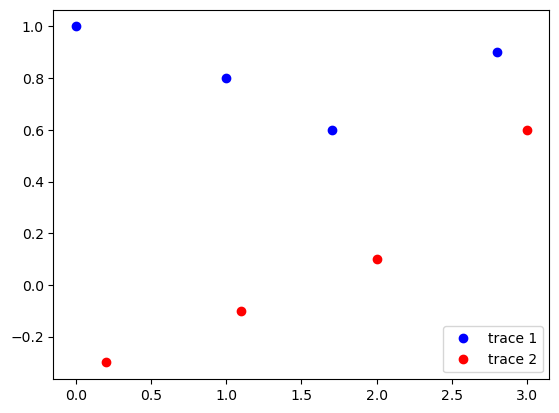

In [4]:
plt.plot(trace1[:, 0], trace1[:, 1], 'bo', label='trace 1')
plt.plot(trace2[:, 0], trace2[:, 1], 'ro', label='trace 2')

plt.legend()

plt.show()

In [5]:
hnorm = np.array([0, 1])
L, sig, n_thicks = thickness_stats_2D(traces, hnorm, min_n=5)

  0%|          | 0/1 [00:00<?, ?it/s]

## Fransfontein Highres

We take a burial model based on seismic data of the Owambo Basin to the north (Miller 2008) given the lack of stratigraphic thickness estimates (and outcrop) from the Northern Margin Zone for the Ediacaran stratigraphy. This burial depth estimate results in conservative estimates for compaction factors that will provide upper bounds on true stratigraphic thicknesses, given that they are based on the thickest foredeep deposits.

The following table shows the inputs used for compaction of the Ghaub (in [`owambo-basin_pybacktrack-well.txt`](owambo-basin_pybacktrack-well.txt)). Note that the ages for the units in the text file are completely irrelevant.

| unit | bottom depth | lithologies |
| --- | --- | --- |
|Owambo Fm         |1100.000    |       Shale           0.62       Silt            0.13       Sand            0.25   |   
|Upper Kombat Fm   |1500.000    |       Shale           0.61       Silt            0.34       Sand            0.05   |   
|Black Shale Mb    |1600.000    |       Shale           1.00    | 
|Lower Komba Fm    |1930.000    |       Silt            0.50       Sand            0.50      |
|Upper Tschudi Fm  |2930.000    |       Silt            0.20       Sand            0.80     | 
|Lower Tschudi Fm  |3380.000    |       Shale           0.90       Sand            0.10      |
|Karibib Fm        |3880.000    |       Dolomite        1.00 |
|Ghaub Fm          |4080.000    |       Dolomite        1.00 |

In [6]:
import pybacktrack

_, decompacted_wells = pybacktrack.backstrip.backstrip_well('owambo-basin_pybacktrack-well.txt', 
                                                            total_sediment_thickness_filename=None,
                                                            well_location=[0, 0])

# take last well (final time step)
ghaub_thick = 200 # present thickness
ghaub_compaction_factor = decompacted_wells[-2].decompacted_stratigraphic_units[-2].decompacted_thickness / ghaub_thick

Compare the above backstripping with a simpler single lithology compaction model.

We need to correct thicknesses for compaction, so let's assume some amount of burial, a typical compaction exponent for carbonates $c_{carb}$, and model a range of burial porosity decreases.

In [7]:
def porosity(z, c, phi0):
    """
    return porosity at a given depth in m for a given exponent c and initial porosity phi0
    athy 1930 model
    """
    return phi0*np.exp(-c*z)

def compaction(z, c, phi0):
    """
    return compaction factor for burial amount, exponent, and initial porosity
    """
    phi1 = porosity(z, c, phi0)
    
    return (1-phi1)/(1-phi0)

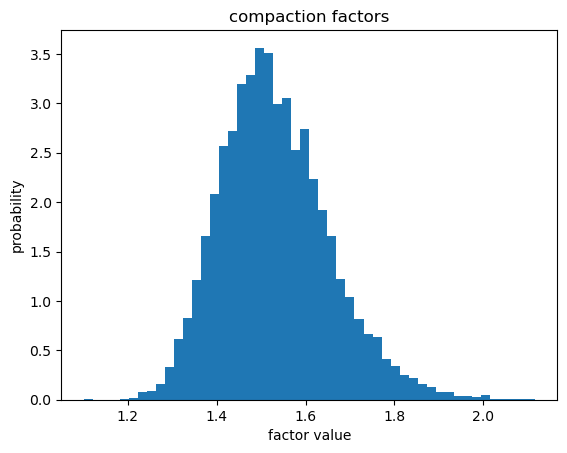

In [8]:
from scipy import stats

n = 10000

phi0 = np.random.normal(0.38, 0.05, size=n)
# c = stats.gennorm.rvs(10, loc=1/1200, scale=1/5000, size=n)
c = stats.gennorm.rvs(10, loc=1/2000, scale=1/5000, size=n)

z = 4000

phis = porosity(z, c, phi0)
fact = compaction(z, c, phi0)

_ = plt.hist(fact, density=True, bins=50)
plt.xlabel('factor value')
plt.ylabel('probability')
plt.title('compaction factors')

plt.show()

In [9]:
traces_df = pd.read_csv('fransfontein_highres_traces_2024-02-15.csv')

# correct for compaction
traces_df['Y'] = traces_df['Y']*ghaub_compaction_factor

trace_ids = traces_df['id'].unique()
n_traces = len(trace_ids)

traces = []

for trace_id in trace_ids:
    cur_idx = traces_df['id'] == trace_id
    traces.append(traces_df.loc[cur_idx][['X', 'Y']].values)

**Compute some basic stats on traces.**

Bed trace point counts

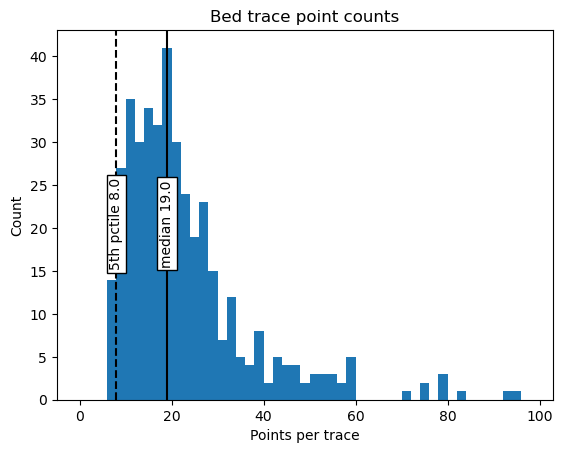

In [10]:
pts_per_trace = np.array([len(trace) for trace in traces])
med_pts = np.median(pts_per_trace)
pct5_pts = np.quantile(pts_per_trace, 0.05)

bins = np.arange(0, 100, 2)
counts, _, _ = plt.hist(pts_per_trace, bins=bins)
# median
plt.axvline(med_pts, color='k')
plt.text(med_pts, np.max(counts)/2, f'median {med_pts}', 
         rotation='vertical', va='center', ha='center',
        bbox=dict(pad=2, facecolor='w'))
# fifth pctile
plt.axvline(pct5_pts, color='k', linestyle='--')
plt.text(pct5_pts, np.max(counts)/2, f'5th pctile {pct5_pts}', 
         rotation='vertical', va='center', ha='center',
        bbox=dict(pad=2, facecolor='w'))

plt.xlabel('Points per trace')
plt.ylabel('Count')
plt.title('Bed trace point counts')

plt.show()

Bed trace distances between points

In [11]:
pt_dists = []
for trace in traces:
    cur_diffs = np.diff(trace, axis=0)
    cur_dists = np.sqrt(np.sum(cur_diffs**2, axis=1))
    pt_dists.append(cur_dists)
pt_dists = np.concatenate(pt_dists, axis=0)

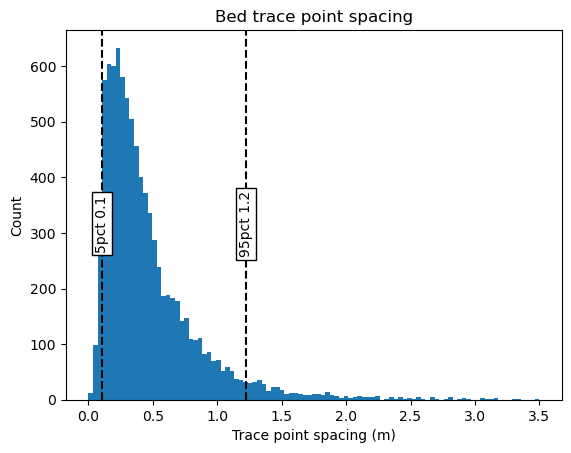

In [12]:
bins = np.linspace(0, 3.5, 100)
counts, _, _ = plt.hist(pt_dists, bins=bins)

# 95 pct
pct95_pt_dists = np.quantile(pt_dists, 0.95)
plt.axvline(pct95_pt_dists, color='k', linestyle='--')
plt.text(pct95_pt_dists, np.max(counts)/2, f'95pct {pct95_pt_dists:1.1f}', 
         rotation='vertical', va='center', ha='center',
        bbox=dict(pad=2, facecolor='w'))
# fifth pctile
pct5_pt_dists = np.quantile(pt_dists, 0.05)
plt.axvline(pct5_pt_dists, color='k', linestyle='--')
plt.text(pct5_pt_dists, np.max(counts)/2, f'5pct {pct5_pt_dists:1.1f}', 
         rotation='vertical', va='center', ha='center',
        bbox=dict(pad=2, facecolor='w'))

plt.xlabel('Trace point spacing (m)')
plt.ylabel('Count')
plt.title('Bed trace point spacing')

plt.show()

Compute $\sigma_{ss}$.

In [13]:
hnorm = np.array([0, 1])

In [14]:
L, sig, n_thicks = thickness_stats_2D(traces, hnorm, min_n=8)

  0%|          | 0/81406 [00:00<?, ?it/s]

C:\Users\adrian\AppData\Local\Temp\ipykernel_26828\3986976686.py:165: RuntimeWarning: invalid value encountered in divide
  cur_sig = np.sqrt(np.sum((cur_thicks/cur_L - 1)**2))


In [15]:
L = np.array(L)
sig = np.array(sig)
n_thicks = np.array(n_thicks)

### Binned data, eye-balled threshold

Filter some data.

In [16]:
# remove really small distances, less than 0.5m
idx = L > 0.3

L_filt = L[idx]
sig_filt = sig[idx]
n_thicks_filt = n_thicks[idx]

Total number of $\sigma_{ss}$ estimates.

In [17]:
print(f'{np.sum(idx)} total estimates')

3442 total estimates


In [18]:
def geo_mean_overflow(iterable):
    return np.exp(np.log(iterable).mean())

def geo_std(iterable):
    return np.exp(np.sqrt(np.sum((np.log(iterable/geo_mean_overflow(iterable)))**2)/len(iterable))) 

def geo_ste(x):
    return np.std(np.log(x))*geo_mean_overflow(x)/np.sqrt(len(x)-1)

In [19]:
nbins = 20

L_bins = np.logspace(np.min(np.log10(L_filt)), np.max(np.log10(L_filt)), nbins)
L_bin_cen = 10**(np.diff(np.log10(L_bins))[0]/2 + np.log10(L_bins)[0:-1])

digitized = np.digitize(L_filt, L_bins)
sig_geomeans = np.array([geo_mean_overflow(sig_filt[digitized == ii]) for ii in range(1, len(L_bins))])
sig_means = np.array([np.mean(sig_filt[digitized == ii]) for ii in range(1, len(L_bins))])
sig_stds = np.array([geo_std(sig_filt[digitized == ii]) for ii in range(1, len(L_bins))])
# geometric standard error
sig_gstes = np.array([geo_ste(sig_filt[digitized == ii]) for ii in range(1, len(L_bins))])

# counts per bin
bin_counts = np.array([np.sum(digitized == x) for x in np.unique(digitized)])

# standard error of log sig
sig_stes = np.array([10**(np.std(np.log10(sig_filt[digitized == ii]))/np.sqrt(np.sum(digitized==ii))) for ii in range(1, len(L_bins))])

In [20]:
K1 = 0.55
K2 = 1
a1 = 0.55
a2 = 1.15

D = np.round(np.exp((np.log(a1)-np.log(a2))/(K1-K2)),1)
D_sig = np.std(D/np.mean(fact)*fact)

Small figure

C:\Users\adrian\AppData\Local\Temp\ipykernel_2096\3577609257.py:1: RuntimeWarning: divide by zero encountered in log10
  l = np.logspace(np.min(np.log10(L)), np.max(np.log10(L)), 100)
C:\Users\adrian\miniconda3\envs\py3.11\Lib\site-packages\numpy\core\function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
C:\Users\adrian\miniconda3\envs\py3.11\Lib\site-packages\numpy\core\function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start


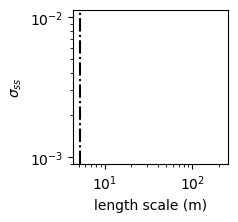

In [22]:
l = np.logspace(np.min(np.log10(L)), np.max(np.log10(L)), 100)

plt.figure(figsize=(2,2))

# plt.loglog(L, sig, '.', markersize=1)
# plt.loglog(L_bin_cen, sig_means)
# plt.errorbar(L_bin_cen, sig_geomeans, yerr=[sig_geomeans-sig_geomeans/sig_stds, sig_geomeans*sig_stds-sig_geomeans], label='geometric mean')

plt.loglog(l[l>D], a2*l[l>D]**-K2, 'k-', label='compensational, $\kappa=$%1.1f' % K2)
plt.loglog(l[l<=D], a1*l[l<=D]**-K1, 'k--', label='non-compensational, $\kappa=$%1.1f' % K1)
plt.axvline(D, label='length scale, D=%1.1f' % D, color='k', linestyle='-.')

plt.xlabel('length scale (m)')
plt.ylabel('$\sigma_{ss}$')

# plt.legend(loc='lower left')

# plt.savefig('figures/sigmass_theory.pdf', format='pdf', bbox_inches='tight')
# 
plt.show()

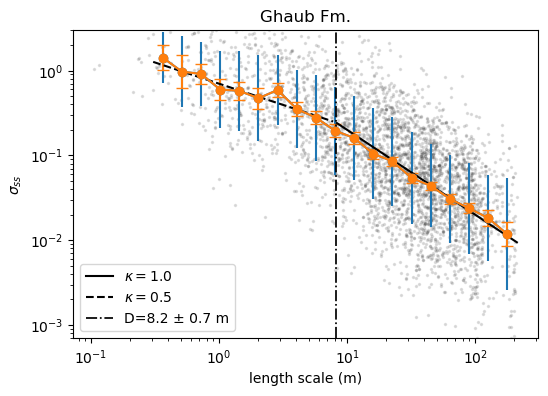

In [21]:
l = np.logspace(np.min(np.log10(L_filt)), np.max(np.log10(L_filt)), 100)

plt.figure(figsize=(6,4))

plt.plot(L, sig, 'k.', markersize=3, alpha=0.1)

plt.errorbar(L_bin_cen, sig_geomeans, 
             yerr=[sig_geomeans-sig_geomeans/sig_stds, sig_geomeans*sig_stds-sig_geomeans], 
             marker='o')
plt.errorbar(L_bin_cen, sig_geomeans, 
             yerr=[sig_geomeans-sig_geomeans/(sig_stes**2), sig_geomeans*(sig_stes**2)-sig_geomeans], 
             marker='o', capsize=4)
# plt.errorbar(L_bin_cen, sig_geomeans, 
#              yerr=[sig_geomeans-sig_stes, sig_geomeans+sig_stes], 
#              marker='o')

K1 = 0.5
K2 = 1
a1 = 0.7
a2 = 2.0

D = np.round(np.exp((np.log(a1)-np.log(a2))/(K1-K2)),1)
D_sig = np.std(D/np.mean(fact)*fact)

plt.loglog(l[l>D], a2*l[l>D]**-K2, 'k-', label='$\kappa=$%1.1f' % K2)
plt.loglog(l[l<=D], a1*l[l<=D]**-K1, 'k--', label='$\kappa=$%1.1f' % K1)
plt.axvline(D, label='D=%1.1f ± %1.1f m' % (D, D_sig), color='k', linestyle='-.', linewidth=1.25)
# plt.axvline(D, label='D', color='k', linestyle='-.', linewidth=1.25)


# plt.loglog(l, a2*l**-K2)
# plt.loglog(l, a1*l**-K1)

plt.xlabel('length scale (m)')
plt.ylabel('$\sigma_{ss}$')
plt.title('Ghaub Fm.')

plt.legend(loc='lower left')

plt.ylim([7e-4, 3e0])

# plt.savefig('figures/fransfontein_D.pdf', format='pdf', bbox_inches='tight')
# plt.savefig('figures/fransfontein_D_blank.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Bayesian Estimate of D

In [22]:
import pymc as pm
import arviz as az

In [23]:
L_log10 = np.log10(L_filt)
sig_log10 = np.log10(sig_filt)

L_bin_cen_log10 = np.log10(L_bin_cen)
sig_geomeans_log10 = np.log10(sig_geomeans)
sig_stds_log10 = np.log10(sig_stds)
sig_stes_log10 = np.log10(sig_stes)

In [24]:
K1 = 0.6
K2 = 1
a1 = 0.8
a2 = 2.0

sig_std_fact = 0.33
sig_ste_fact = 2

b1_mu = np.log10(a1)
b2_mu = np.log10(a2)
D_lower = np.log10(1)
D_upper = np.log10(100)

l_log10 = np.log10(l)

D = np.round(np.exp((np.log(a1)-np.log(a2))/(K1-K2)),1)
D_log10 = np.log10(D)
D_log10 = (b1_mu-b2_mu)/(K1-K2)

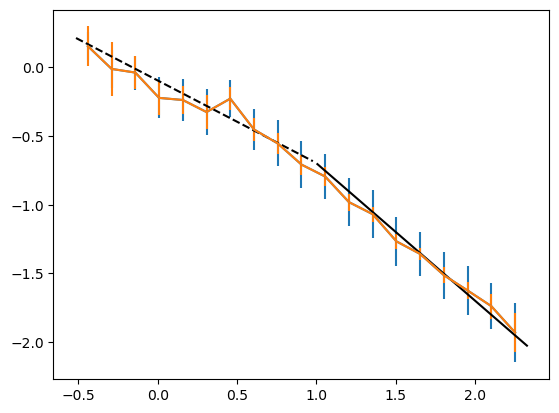

In [25]:
plt.errorbar(L_bin_cen_log10,  sig_geomeans_log10, sig_stds_log10*sig_std_fact)
plt.errorbar(L_bin_cen_log10,  sig_geomeans_log10, sig_stes_log10*sig_ste_fact)
plt.plot(l_log10[l_log10>D_log10], b2_mu - l_log10[l_log10>D_log10], 'k-', label='$\kappa=$%1.1f' % K2)
plt.plot(l_log10[l_log10<=D_log10], b1_mu - K1*l_log10[l_log10<=D_log10], 'k--', label='$\kappa=$%1.1f' % K2)
# plt.plot(l[l<=D], a1*l[l<=D]**-K1, 'k--', label='$\kappa=$%1.1f' % K1)

In [26]:
model = pm.Model()

with model:
    # data variance
    # intercept of non-compensational term
    b1 = pm.Normal('b1', mu=b1_mu, sigma=0.5)
    # factor to add to b1
    # eta = pm.Gamma('eta', alpha=eta_mu**2/eta_sig**2, beta=eta_mu/eta_sig**2)
    # intercept of compensational term
    # b2 = b1 + eta
    b2 = pm.Normal('b2', mu=b2_mu, sigma=0.5)
    # non-compensational exponent
    K1 = pm.Uniform('K1', lower=0, upper=1)
    # compensation length scale
    D = pm.Deterministic('D', (b1-b2)/(K1-1))

    # keep D small
    pm.Potential('restrict_D_upper', pm.math.switch(D < 2, 0., -np.inf))
    pm.Potential('restrict_D_lower', pm.math.switch(D > 0, 0., -np.inf))

    # set up piecewise portion
    sig_ss = pm.math.switch(D >= L_bin_cen_log10, -K1*L_bin_cen_log10 + b1, -L_bin_cen_log10 + b2)
    
    sampling_dist = pm.Normal('sampling_dist', mu=sig_ss, sigma=sig_stes_log10*sig_ste_fact, observed=sig_geomeans_log10)

In [27]:
with model:
    idata = pm.sample(20000, chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b1, b2, K1]


Output()

Sampling 4 chains for 1_000 tune and 20_000 draw iterations (4_000 + 80_000 draws total) took 65 seconds.
There were 1127 divergences after tuning. Increase `target_accept` or reparameterize.


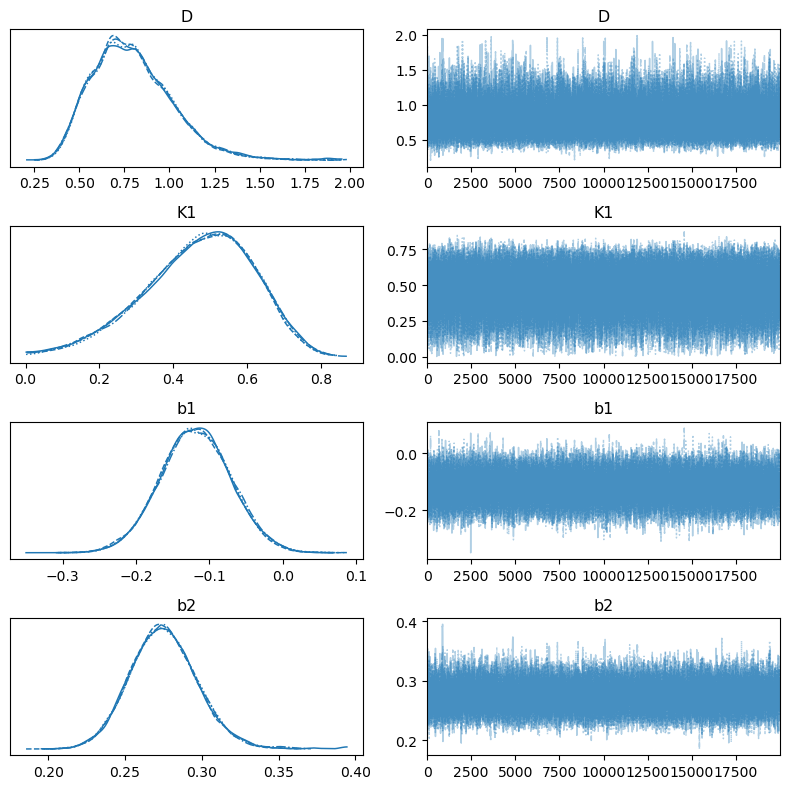

In [28]:
az.plot_trace(idata, compact=True, figsize=(8, 8), divergences=None)
plt.tight_layout()

In [29]:
n_samps = 1000
samps = az.extract(idata, num_samples=n_samps)

a1_samps = 10**samps.b1.values
a2_samps = 10**samps.b2.values
K1_samps = samps.K1.values
D_samps = 10**samps.D.values

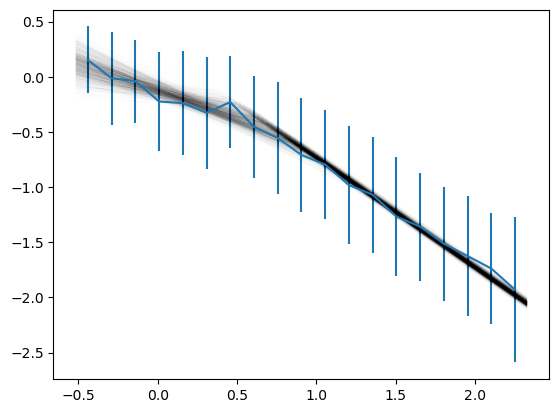

In [30]:
plt.errorbar(L_bin_cen_log10,  sig_geomeans_log10, sig_stds_log10/1)
for ii in range(n_samps): 
    plt.plot(l_log10[l_log10>samps.D.values[ii]],
             samps.b2.values[ii] - l_log10[l_log10>samps.D.values[ii]], 
             'k-', alpha=0.01, linewidth=0.5)
    plt.plot(l_log10[l_log10<=samps.D.values[ii]], 
             samps.b1.values[ii] - samps.K1.values[ii]*l_log10[l_log10<=samps.D.values[ii]], 
             'k-', alpha=0.01, linewidth=0.5)
# plt.plot(l[l<=D], a1*l[l<=D]**-K1, 'k--', label='$\kappa=$%1.1f' % K1)

In [31]:
# get random subset with effective sample size
n_D_eff = np.round(az.ess(idata).D.values).astype(int)
D_post = 10**(az.extract(idata, num_samples=n_D_eff).D.values)

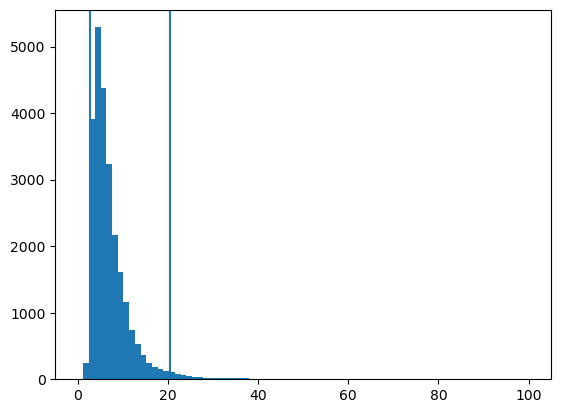

In [32]:
_ = plt.hist(D_post, bins=np.linspace(0, 100, 80))
plt.axvline(np.quantile(D_post, 0.025))
plt.axvline(np.quantile(D_post, 0.975))

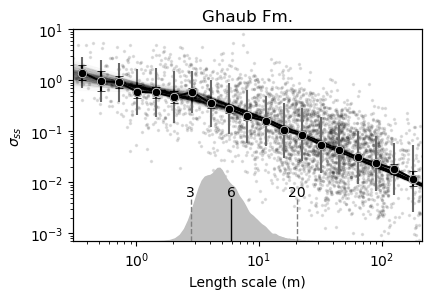

In [33]:
l = np.logspace(np.min(np.log10(L_filt)), np.max(np.log10(L_filt)), 100)

fig = plt.figure(figsize=(4.5, 2.75))

ax1 = plt.axes(xscale='log', yscale='log')

# plot data and binned data
ax1.plot(L_filt, sig_filt, 'k.', markersize=3, alpha=0.1)
ax1.errorbar(L_bin_cen, sig_geomeans, 
             yerr=[sig_geomeans-sig_geomeans/sig_stds, sig_geomeans*sig_stds-sig_geomeans], 
             marker='o', color='dimgray')
plt.errorbar(L_bin_cen, sig_geomeans, 
             yerr=[sig_geomeans-sig_geomeans/(sig_stes**2), sig_geomeans*(sig_stes**2)-sig_geomeans], 
             marker='o', capsize=3, markeredgecolor='gainsboro', markeredgewidth=0.5, color='k')

# plot some fits
for ii in range(n_samps): 
    ax1.plot(l[l>D_samps[ii]],
             a2_samps[ii]*l[l>D_samps[ii]]**(-1), 
             'k-', alpha=0.01, linewidth=0.5)
    plt.plot(l[l<=D_samps[ii]], 
             a1_samps[ii]*l[l<=D_samps[ii]]**(-K1_samps[ii]), 
             'k-', alpha=0.01, linewidth=0.5)

ax2 = ax1.twinx()
l_kde, D_kde = az.kde(D_post, custom_lims=(1, 100))
ax2.fill_between(l_kde, D_kde, color='silver')

# credible interval
q1 = 0.025
q2 = 0.975
ax2.axvline(np.quantile(D_post, q1), ymax=0.2, color='gray', linestyle='--', linewidth=1)
ax2.text(np.quantile(D_post, q1), 0.1, 
         f'{np.quantile(D_post, q1):1.0f}', va='bottom', ha='center')
ax2.axvline(np.quantile(D_post, q2), ymax=0.2, color='gray', linestyle='--', linewidth=1)
ax2.text(np.quantile(D_post, q2), 0.1, 
         f'{np.quantile(D_post, q2):1.0f}', va='bottom', ha='center')
ax2.axvline(10**idata.median().posterior.D.values,
            ymax=0.2, color='black', linestyle='-', linewidth=1)
ax2.text(10**idata.median().posterior.D.values, 0.1, 
         f'{10**idata.median().posterior.D.values:1.0f}', va='bottom', ha='center')


# ax2.legend()
ax2.set_ylim([0, 0.5])
ax2.set_yticklabels([])
ax2.tick_params(axis='y', right=False)


ax1.set_xlabel('Length scale (m)')
ax1.set_ylabel('$\sigma_{ss}$')
ax1.set_title('Ghaub Fm.')

ax1.set_ylim([7e-4, 10])
ax1.set_xlim([np.min(l), np.max(l)])

plt.savefig('figures/fransfontein_D.pdf', format='pdf', bbox_inches='tight', transparent=True)

plt.show()

### Plot posterior of sub-compensational exponent

In [34]:
n_K1_eff = np.round(az.ess(idata).K1.values).astype(int)
K1_post = az.extract(idata, num_samples=n_K1_eff).K1.values

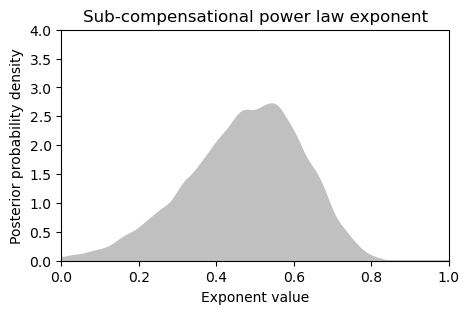

In [36]:
plt.figure(figsize=(5,3))

l_kde, K1_kde = az.kde(K1_post, custom_lims=[0, 1])
plt.fill_between(l_kde, K1_kde, color='silver')
plt.xlim([0, 1])
plt.ylim([0, 4])

plt.xlabel('Exponent value')
plt.ylabel('Posterior probability density')
plt.title('Sub-compensational power law exponent')

plt.savefig('figures/sub-compensation_exponent.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/sub-compensation_exponent.png', format='png', dpi=300, bbox_inches='tight')

plt.show()